In [2]:
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns
sns.set_theme()

<Figure size 640x480 with 0 Axes>

In [3]:
def load_img(fn):
	I = plt.imread(fn)
	I = np.array(I,dtype=bool)
	return I

def load_motor(fn):
	motor = []
	with open(fn,'r') as fid:
		lines = fid.readlines()
	lines = [l.strip() for l in lines]
	for myline in lines:
		if myline =='START': # beginning of character
			stk = []
		elif myline =='BREAK': # break between strokes
			stk = np.array(stk)
			motor.append(stk) # add to list of strokes
			stk = []
		else:
			arr = np.fromstring(myline,dtype=float,sep=',')
			stk.append(arr)
	return motor

def space_motor_to_img(pt):
	pt[:,1] = -pt[:,1]
	return pt

def space_img_to_motor(pt):
	pt[:,1] = -pt[:,1]
	return

def get_color(k):
    scol = ['r','g','b','m','c']
    ncol = len(scol)
    if k < ncol:
       out = scol[k]
    else:
       out = scol[-1]
    return out

def num2str(idx):
	if idx < 10:
		return '0'+str(idx)
	return str(idx)

In [4]:
img_dir = Path('../datasets/omniglot/python/images_background/Latin/')
stroke_dir = Path('../datasets/omniglot/python/strokes_background/strokes_background/Latin/')

In [239]:
n_characters = len([x for x in img_dir.glob('*')])

dataset = []
for char_int in range(1, n_characters + 1):
    character_id = num2str(char_int)
    stroke_char_dir = stroke_dir / ('character' + character_id)
    img_char_dir = img_dir / ('character' + character_id)

    stroke_files = [x for x in stroke_char_dir.glob('*')]
    char_id = stroke_files[0].name[:4]
    n_samples = len(stroke_files)

    character_data = defaultdict(list)
    for i in range(1, n_samples+1):
        character_stroke_file = stroke_char_dir / (char_id + '_' + num2str(i) + '.txt')
        character_img_file = img_char_dir / (char_id + '_' + num2str(i) + '.png')
        motor = load_motor(character_stroke_file)
        img = load_img(character_img_file)

        character_data['img'].append(img)
        character_data['motor'].append(motor)

    dataset.append(character_data)

In [220]:
def plot_traj(stk, color, lw, ax):
	n = stk.shape[0]
	if n > 1:
		ax.plot(stk[:,0],stk[:,1],color=color, linewidth=lw)
	else:
		ax.plot(stk[0,0],stk[0,1],color=color, linewidth=lw,marker='.')

def plot_motor_to_image(I, drawing, ax, lw=2):
	drawing = [d[:,0:2] for d in drawing] # strip off the timing data (third column)
	drawing = [space_motor_to_img(d) for d in drawing] # convert to image space
	ax.imshow(I,cmap='gray')
	ns = len(drawing)
	for sid in range(ns): # for each stroke
		plot_traj(drawing[sid], get_color(sid), lw, ax)
	ax.set_xticks([])
	ax.set_yticks([])

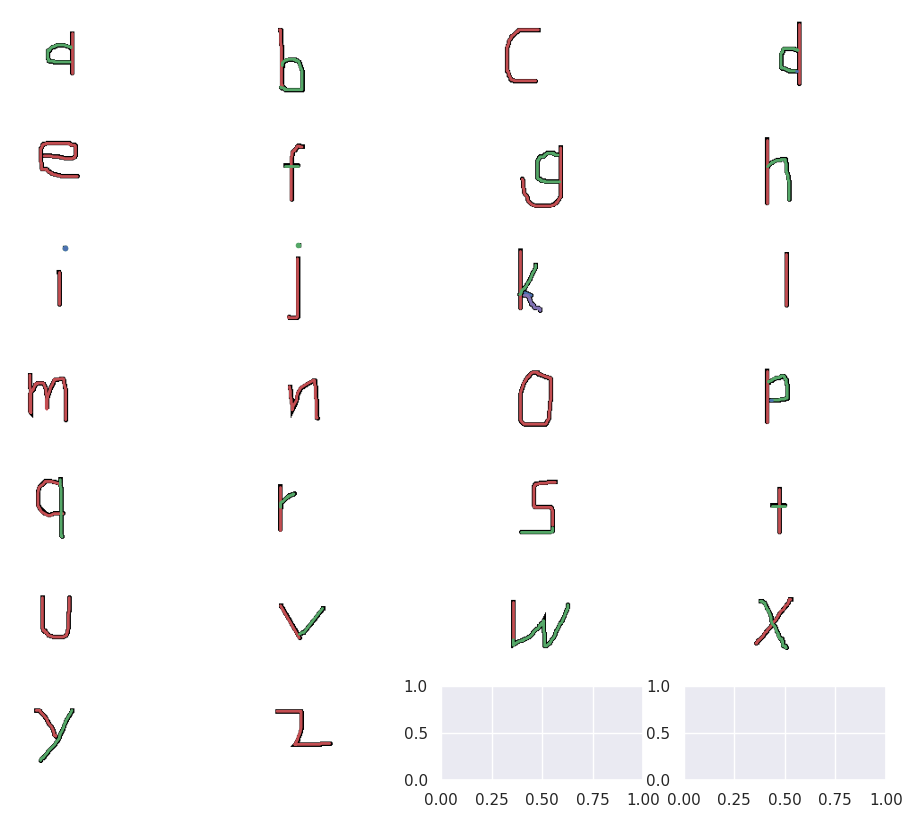

In [221]:
n_cols = 4
n_rows = int(np.ceil(n_characters / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,10))
for char_idx in range(n_characters):
    row_idx = char_idx // n_cols
    col_idx = char_idx % n_cols
    ax = axs[row_idx, col_idx]
    plot_motor_to_image(dataset[char_idx]['img'][0], dataset[char_idx]['motor'][0], ax, lw=2)

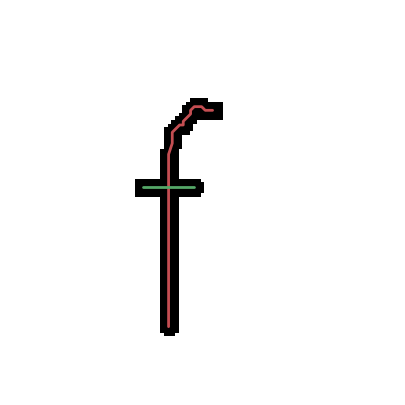

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot_motor_to_image(dataset[5]['img'][0], dataset[5]['motor'][0], ax)
# ax.plot((0,100), (0,100))

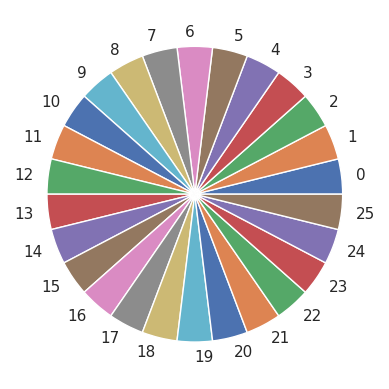

In [9]:
char_counts = {i: len(x['img']) for i, x in enumerate(dataset)}
plt.pie(char_counts.values(), labels=char_counts.keys())
plt.show()

In [142]:
def stroke_to_canvas(stroke_sample, canvas_size, max_x = 100, max_y = 100):
    canvas = np.zeros((canvas_size, canvas_size, 2))
    sequence = []

    count = 1
    for stroke in stroke_sample:
        last_point = None
        for point in stroke:
            y_idx = round(canvas_size * (point[0] / max_x))
            x_idx = round(canvas_size * (point[1] / max_y))

            if last_point is not None:
                x_diff = x_idx - last_point[0]
                y_diff = y_idx - last_point[1]
                if abs(x_diff) > 1:
                    direction = -1 if x_diff > 0 else 1
                    for i in range(1, abs(x_diff)):
                        fill_x_idx = x_idx + (direction*i)
                        canvas[fill_x_idx, y_idx, 0] = 1
                        sequence.append([fill_x_idx, y_idx])
                        canvas[fill_x_idx, y_idx, 1] = count
                        count += 1
                if abs(y_diff) > 1:
                    direction = -1 if y_diff > 0 else 1
                    for i in range(1, abs(y_diff)):
                        fill_y_idx = y_idx+(direction*i)
                        canvas[x_idx, fill_y_idx, 0] = 1
                        sequence.append([x_idx, fill_y_idx])
                        canvas[x_idx, fill_y_idx, 1] = count
                        count += 1

            canvas[x_idx, y_idx, 0] = 1
            sequence.append([x_idx, y_idx])
            canvas[x_idx, y_idx, 1] = count
            count += 1

            last_point = (x_idx, y_idx)

    return canvas, np.array(sequence)

In [143]:
stroke_sample = dataset[1]['motor'][0]

Text(0.5, 1.0, 'Sequence')

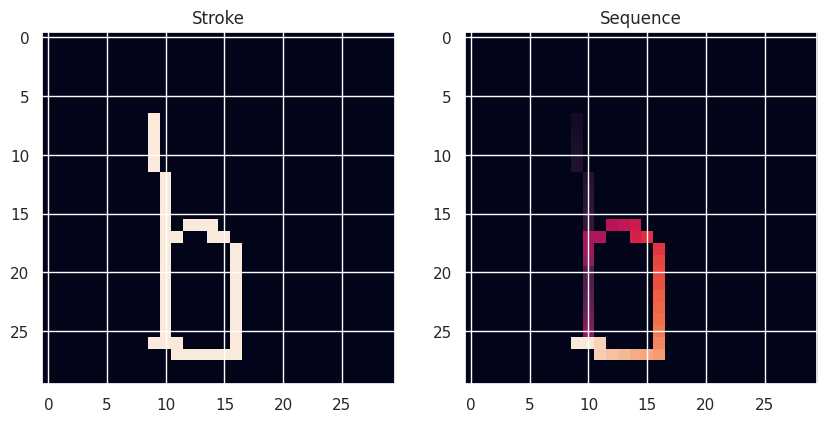

In [144]:
canvas_size = 30
canvas, sequence = stroke_to_canvas(stroke_sample, canvas_size)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(canvas[:,:,0])
axs[0].set_title('Stroke')
axs[1].imshow(canvas[:,:,1])
axs[1].set_title('Sequence')

In [174]:
def filter_duplicates(sequence):
    unique_array = [sequence[0]]
    for i in range(1, len(sequence)):
        if not np.array_equal(sequence[i], sequence[i - 1]):
            unique_array.append(sequence[i])

    return np.array(unique_array)

def plot_sequence(sequence, canvas_size=100):
    canvas = np.zeros((canvas_size, canvas_size))
    for x,y in sequence:
        canvas[x,y] = 1

    plt.imshow(canvas)

In [175]:
filtered_sequence = filter_duplicates(sequence)

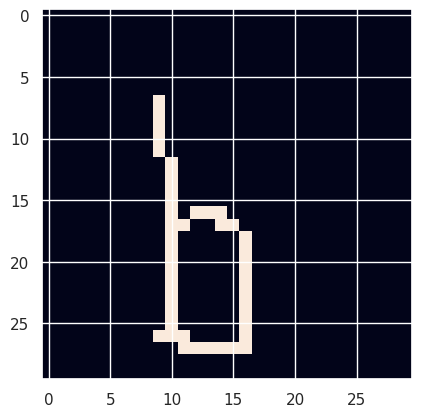

In [178]:
plot_sequence(filtered_sequence, canvas_size=canvas_size)

In [237]:
import copy

def filter_duplicates(sequence):
    unique_array = [sequence[0]]
    for i in range(1, len(sequence)):
        if not np.array_equal(sequence[i], sequence[i - 1]):
            unique_array.append(sequence[i])

    return np.array(unique_array)


def process_training_samples(sequence, canvas_size):
    canvas_list = []
    pixel_list = []
    canvas = np.zeros((canvas_size, canvas_size))
    for x, y in sequence:
        canvas[x,y] = 1

        canvas_list.append(copy.deepcopy(canvas))
        pixel_list.append([x / canvas_size, y / canvas_size])

    return canvas_list, pixel_list

In [241]:
canvas_data = []
pixel_data = []
for character_data in dataset:
    for stroke_sample in character_data['motor']:
        sequence = get_sequence(stroke_sample, canvas_size)
        canvas_list, pixel_list = process_training_samples(sequence, canvas_size)
        canvas_data += canvas_list
        pixel_data += pixel_list

canvas_data = np.array(canvas_data)
pixel_data = np.array(pixel_data)

IndexError: index -31 is out of bounds for axis 0 with size 30

In [227]:
import torch
from torch.utils.data import Dataset, DataLoader

In [234]:
dataset = StrokeDataset(images=canvas_data, pixels=pixel_data)
dataloader = DataLoader(dataset=dataset, batch_size=32)

In [235]:
img, px = next(iter(dataloader))

In [ ]:
# input
current_canvas

# output
pixel